# Neural Symbolic Learner# NeuralSymbolic - Demo

## Dependencies

In [ ]:
!pip install keras-rectified-adam
!pip install keras.utils
!pip install keras
!pip install tqdm
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install matplotlib
!pip install tensorflow-addons
!pip install scikit-learn
!pip install keras-adabound
!pip install pydot
!pip install graphviz

  Preparing metadata (setup.py) ... done
  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.20.0-py3-none-any.whl size=8255 sha256=81cf3ca2c42a3e46382500fa2a0f85d0be7a1ed44b2e11c4ea341411b287a51e
  Stored in directory: /root/.cache/pip/wheels/24/fe/0f/dcf898210ceef6ae45cea51d3d27765f38bce2b4dc8e88245f
Successfully built keras-rectified-adam
  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2632 sha256=2030f3a59507bd967ec0230f5ba9fdfb9d5cfe026399cbcb045b3f9f793d1caa
  Stored in directory: /root/.cache/pip/wheels/5c/c0/b3/0c332de4fd71f3733ea6d61697464b7ae4b2b5ff0300e6ca7a
Successfully built keras.utils
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently

In [25]:
import tqdm
import numpy as np
import pandas as pd
import keras
import sklearn
from sklearn.model_selection import LeaveOneOut
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import plot_model
# from tensorflow_addons.optimizers import RectifiedAdam
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')


In [28]:
from keras import backend as K
import tensorflow as tf
import numpy as np
import random
import os

seed_value = 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ["PYTHONHASHSEED"] = str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed_value)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)


## Import Data from CSV

In [29]:
# path to the data
path = "trains-100-mod.csv"
str_att = {
    "length": ["short", "long"],
    "shape": [
        'engine',
    'closedrect',
    'openrect',
    'dblclosedrect',
    'dblopnrect',
    'ellipse',
    'hexagon',
    'jaggedtop',
    'closedtrap',
    'opentrap',
    'slopetoprect',
    'slopetoptrap',
    'closedushaped',
    'openushaped',
    'dblslopetoprect'
    ],
    "load_shape": ["circlelod", "hexagonlod", "rectanglod", "trianglod"],
    "Class_attribute": ["west", "east"],
}


def read_data(path=path):
    df = pd.read_csv(path)

    for k in df:
        for att in str_att:
            if k.startswith(att):
                for i, val in enumerate(df[k]):
                    if val in str_att[att]:
                        df[k][i] = str_att[att].index(val)

    df.replace("\\0", 0, inplace=True)
    df.replace("None", -1, inplace=True)

    return df


df = read_data()
df = df.drop("Unnamed: 0", axis = 1)
# The scope of these changes made to
# pandas settings are local to with statement.
with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,
                       ):
    print(df.columns)


Index(['Number_of_cars', 'Number_of_different_loads', 'num_wheels1', 'length1',
       'shape1', 'num_loads1', 'load_shape1', 'num_wheels2', 'length2',
       'shape2', 'num_loads2', 'load_shape2', 'num_wheels3', 'length3',
       'shape3', 'num_loads3', 'load_shape3', 'num_wheels4', 'length4',
       'shape4', 'num_loads4', 'load_shape4', 'num_wheels5', 'length5',
       'shape5', 'num_loads5', 'load_shape5', 'Class_attribute',
       'Rectangle_next_to_rectangle', 'Rectangle_next_to_triangle',
       'Rectangle_next_to_hexagon', 'Rectangle_next_to_circle',
       'Triangle_next_to_triangle', 'Triangle_next_to_hexagon',
       'Triangle_next_to_circle', 'Hexagon_next_to_hexagon',
       'Hexagon_next_to_circle', 'Circle_next_to_circle'],
      dtype='object')


In [30]:
display(df)

,Number_of_cars,Number_of_different_loads,num_wheels1,length1,shape1,num_loads1,load_shape1,num_wheels2,length2,shape2,...,Rectangle_next_to_rectangle,Rectangle_next_to_triangle,Rectangle_next_to_hexagon,Rectangle_next_to_circle,Triangle_next_to_triangle,Triangle_next_to_hexagon,Triangle_next_to_circle,Hexagon_next_to_hexagon,Hexagon_next_to_circle,Circle_next_to_circle
0,4,3,2,1,1,3,2,2,0,2,...,0,1,0,0,0,0,0,0,0,0
1,4,2,2,0,2,1,0,2,0,8,...,0,0,0,0,0,0,1,0,0,0
2,4,3,2,0,1,1,0,2,0,2,...,0,1,0,0,0,0,0,0,0,0
3,5,3,2,0,2,1,2,2,1,2,...,1,1,0,0,0,0,1,0,0,0
4,4,3,2,0,13,1,2,2,0,8,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,3,2,1,4,1,3,2,0,9,...,0,0,0,0,1,0,1,0,0,0
96,3,2,2,1,1,3,3,2,0,6,...,0,0,0,0,0,0,1,0,0,0
97,3,2,3,1,1,1,2,2,0,10,...,0,0,0,1,0,0,0,0,0,0
98,3,1,2,1,2,1,3,2,0,10,...,0,0,0,0,0,0,1,0,0,0


In [31]:
# # path to the data
# path = "trains-100-mod.csv"
# str_att = {
#     "length": ["short", "long"],
#     "shape": [
#         "closedrect",
#         "dblopnrect",
#         "ellipse",
#         "engine",
#         "hexagon",
#         "jaggedtop",
#         "openrect",
#         "opentrap",
#         "slopetop",
#         "ushaped",
#     ],
#     "load_shape": ["circlelod", "hexagonlod", "rectanglod", "trianglod"],
#     "Class_attribute": ["west", "east"],
# }


# def read_data(path=path):
#     df = pd.read_csv(path)

#     for k in df:
#         for att in str_att:
#             if k.startswith(att):
#                 for i, val in enumerate(df[k]):
#                     if val in str_att[att]:
#                         df[k][i] = str_att[att].index(val)

#     df.replace("\\0", 0, inplace=True)
#     df.replace("None", -1, inplace=True)

#     return df


# df = read_data()
# # The scope of these changes made to
# # pandas settings are local to with statement.
# with pd.option_context('display.max_rows', None,
#                        'display.max_columns', None,
#                        'display.precision', 3,
#                        ):
#     print(df)


## Question 1.

Implemente uma solução que implemente proposicionalização com 32 neurônios
de entrada e uma única saída (denotando leste).

In [32]:
df = read_data()
df = df.drop("Unnamed: 0", axis = 1)

Y = np.array(df.pop('Class_attribute'))
X = np.array(df)


In [33]:
X[0]

array([4, 3, 2, 1, 1, 3, 2, 2, 0, 2, 1, 3, 2, 1, 2, 1, 2, 2, 0, 0, 0, '0',
       0, '0', '0', 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=object)

### Akin Propositionalization Model

In [34]:
# define model
def model_1():
    model = Sequential(
        [
            Dense(9, activation="linear", input_shape=(len(df.keys()),)),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(
        loss=binary_crossentropy, optimizer = 'adam', metrics=["accuracy"]
    )
    return model


es = keras.callbacks.EarlyStopping(
    monitor="val_loss", min_delta=0, patience=1000, verbose=0
)

model = model_1()
model.summary()


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                     │ (None, 9)                   │             342 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 352 (1.38 KB)

 Trainable params: 352 (1.38 KB)

 Non-trainable params: 0 (0.00 B)

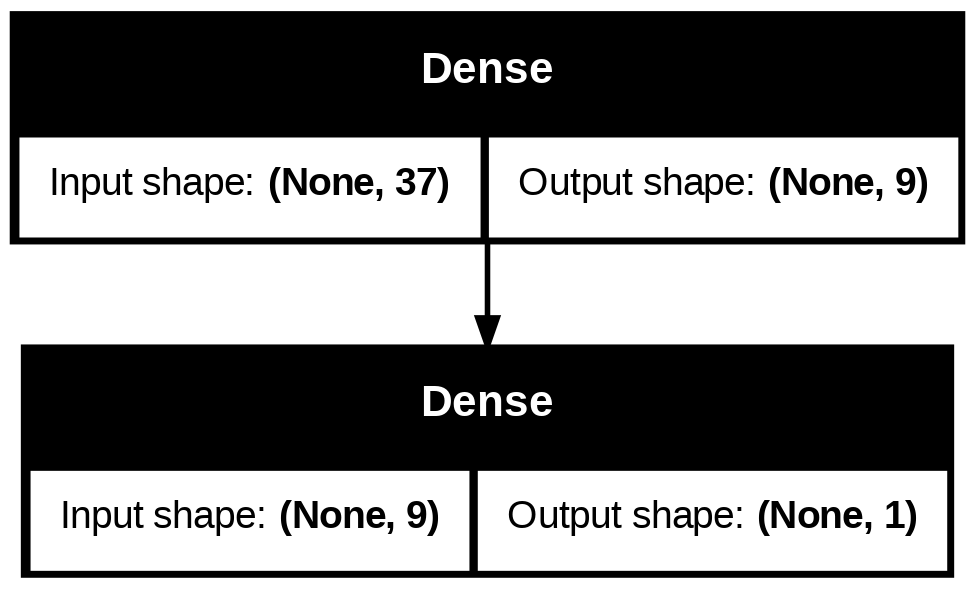

In [35]:
plot_model(model, show_shapes=True, show_layer_names=False)

### Train

In [60]:
from sklearn.model_selection import train_test_split

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

X = np.asarray(X).astype(float)
Y = np.asarray(Y).astype(int)

# dados em 70% treino e 30% teste
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Criação do modelo
model = model_1()

# Treinamento do modelo
hist_1 = model.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=10000,
    verbose=0,
    callbacks = [callback]
)


Test loss: 0.7960876226425171
Test accuracy: 0.699999988079071
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
              precision    recall  f1-score   support

           0       0.68      0.81      0.74        16
           1       0.73      0.57      0.64        14

    accuracy                           0.70        30
   macro avg       0.71      0.69      0.69        30
weighted avg       0.70      0.70      0.69        30



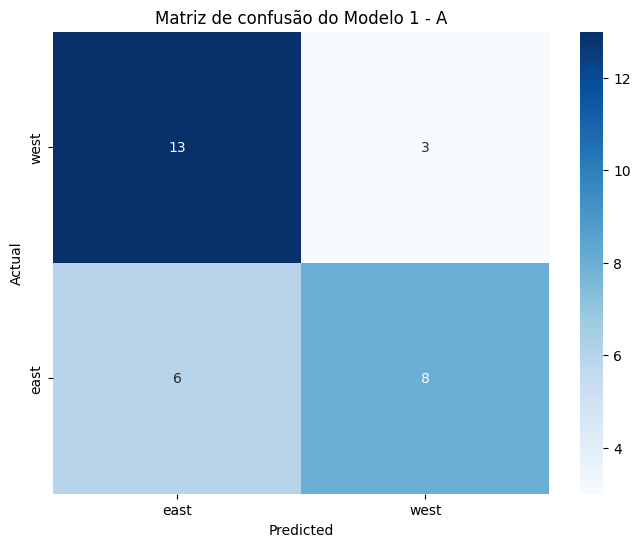

In [61]:
# Avaliação do modelo
score = model.evaluate(x_test, y_test, verbose=0)

print("Test loss:", score[0])
print("Test accuracy:", score[1])

pred_prob = model.predict(x_test)
y_pred = 1*(pred_prob > 0.5)

report = sklearn.metrics.classification_report(y_test, y_pred)
print(report)
cm1 = sklearn.metrics.confusion_matrix(y_test.reshape(-1, 1), y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, cmap = 'Blues', fmt = 'd', xticklabels = ["east", "west"], yticklabels = ["west", "east"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de confusão do Modelo 1 - A')
plt.show()

#plotando a matriz de confusão com o heatmap da bilbioteca seaborn


In [62]:
from sklearn.model_selection import KFold

# Converta X e Y para arrays NumPy com tipos de dados apropriados
X = np.asarray(X).astype(np.float32)
Y = np.asarray(Y).astype(np.int32)

# Definir o número de folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

losses = []
accuracies = []
fold_losses = []
fold_accuracies = []

# Iterar sobre cada fold
for train_index, test_index in kf.split(X):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    # Criação do modelo
    model = model_1()

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Treinamento do modelo
    hist = model.fit(
        x_train,
        y_train,
        validation_data=(x_test, y_test),
        epochs=5000,
        verbose=0,
        callbacks=[callback]
    )

    # Armazenar a perda e a precisão de cada época
    fold_losses.append(hist.history['val_loss'])
    fold_accuracies.append(hist.history['val_accuracy'])

    # Avaliação do modelo
    score = model.evaluate(x_test, y_test, verbose=0)
    losses.append(score[0])
    accuracies.append(score[1])

# Determinar o número máximo de épocas treinadas em qualquer fold
max_epochs = max(len(losses) for losses in fold_losses)

# Criar um eixo X com o número máximo de épocas
epochs = np.arange(1, max_epochs + 1)

# Média e desvio padrão das métricas
mean_loss = np.mean(losses)
std_loss = np.std(losses)
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)


K-Fold Cross-Validation Results: 5 folds
Mean Loss: 0.6685 (+/- 0.1218)
Mean Accuracy: 0.5800 (+/- 0.0812)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.73      0.67      0.70        12

    accuracy                           0.65        20
   macro avg       0.64      0.65      0.64        20
weighted avg       0.66      0.65      0.65        20

[[5 3]
 [4 8]]


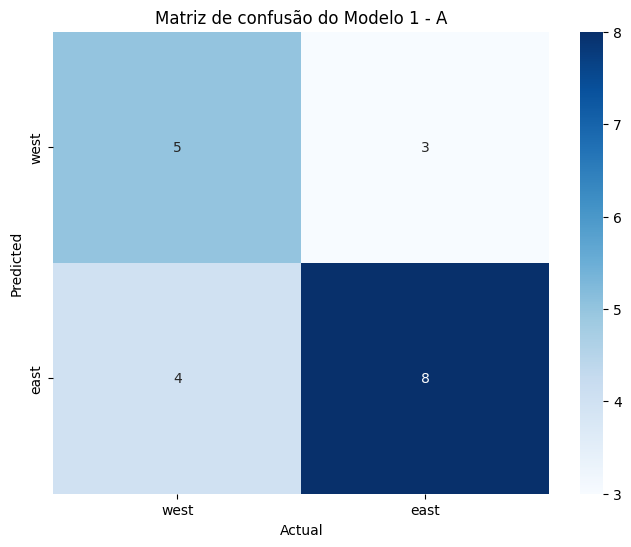

In [63]:
print(f"K-Fold Cross-Validation Results: {k} folds")
print(f"Mean Loss: {mean_loss:.4f} (+/- {std_loss:.4f})")
print(f"Mean Accuracy: {mean_accuracy:.4f} (+/- {std_accuracy:.4f})")

pred_prob = model.predict(x_test)
y_pred = 1*(pred_prob > 0.5)

report = sklearn.metrics.classification_report(y_test, y_pred)
print(report)

cm1 = sklearn.metrics.confusion_matrix(y_test.reshape(-1, 1), y_pred)
print(cm1)

#plotando a matriz de confusão com o heatmap da bilbioteca seaborn

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, cmap = 'Blues', fmt = 'd', xticklabels = ["west", "east"], yticklabels = ["west", "east"])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Matriz de confusão do Modelo 1 - A')
plt.show()

### Results

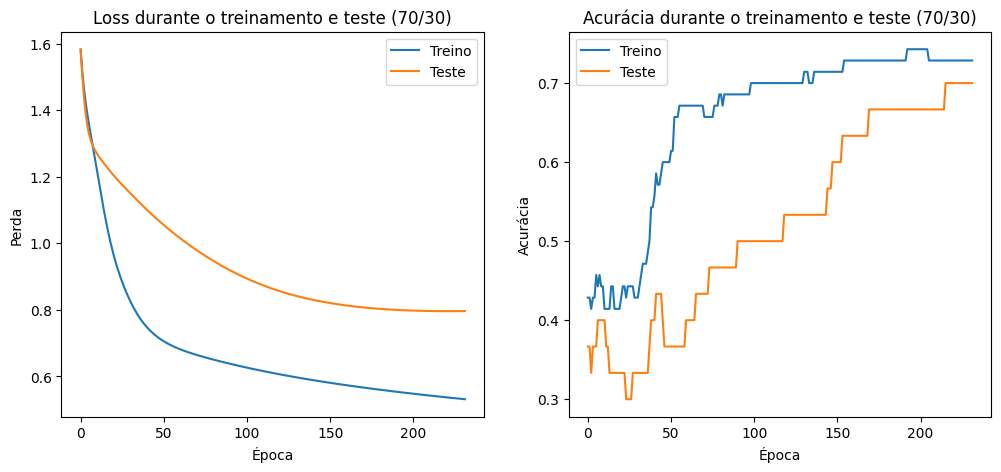

In [64]:
import matplotlib.pyplot as plt

# Plotando os resultados do treinamento 70/30
plt.figure(figsize=(12, 5))

# Plotando a perda
plt.subplot(1, 2, 1)
plt.plot(hist_1.history['loss'], label='Treino')
plt.plot(hist_1.history['val_loss'], label='Teste')
plt.title('Loss durante o treinamento e teste (70/30)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

# Plotando a acurácia
plt.subplot(1, 2, 2)
plt.plot(hist_1.history['accuracy'], label='Treino')
plt.plot(hist_1.history['val_accuracy'], label='Teste')
plt.title('Acurácia durante o treinamento e teste (70/30)')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


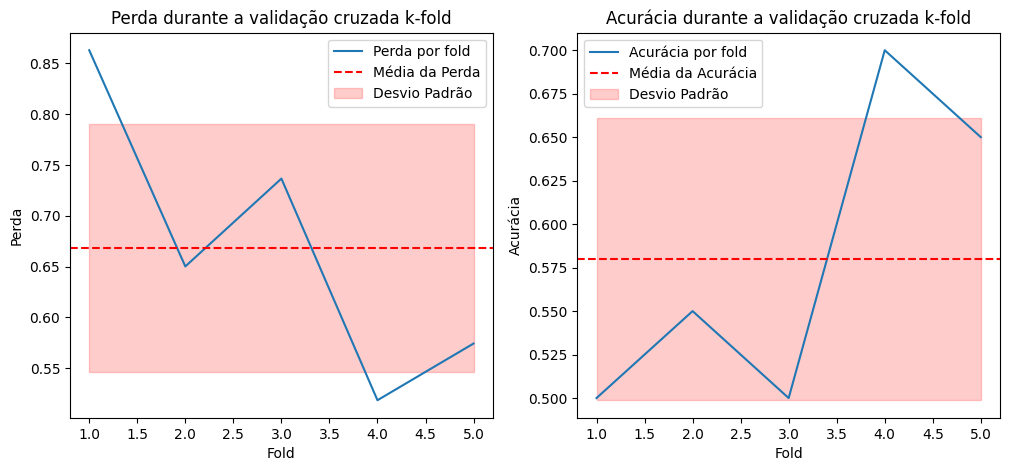

In [65]:
# Resultados da validação cruzada k-fold
epochs = list(range(1, len(losses) + 1))

# Plotando as perdas
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Perda por fold')
plt.axhline(y=mean_loss, color='r', linestyle='--', label='Média da Perda')
plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, color='r', alpha=0.2, label='Desvio Padrão')
plt.title('Perda durante a validação cruzada k-fold')
plt.xlabel('Fold')
plt.ylabel('Perda')
plt.legend()

# Plotando as acurácias
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Acurácia por fold')
plt.axhline(y=mean_accuracy, color='r', linestyle='--', label='Média da Acurácia')
plt.fill_between(epochs, mean_accuracy - std_accuracy, mean_accuracy + std_accuracy, color='r', alpha=0.2, label='Desvio Padrão')
plt.title('Acurácia durante a validação cruzada k-fold')
plt.xlabel('Fold')
plt.ylabel('Acurácia')
plt.legend()

plt.show()


In [22]:
pred_prob = model.predict(x_test)
y_pred = 1*(pred_prob > 0.5)

report = sklearn.metrics.classification_report(y_test, y_pred)
print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.73      0.67      0.70        12

    accuracy                           0.65        20
   macro avg       0.64      0.65      0.64        20
weighted avg       0.66      0.65      0.65        20



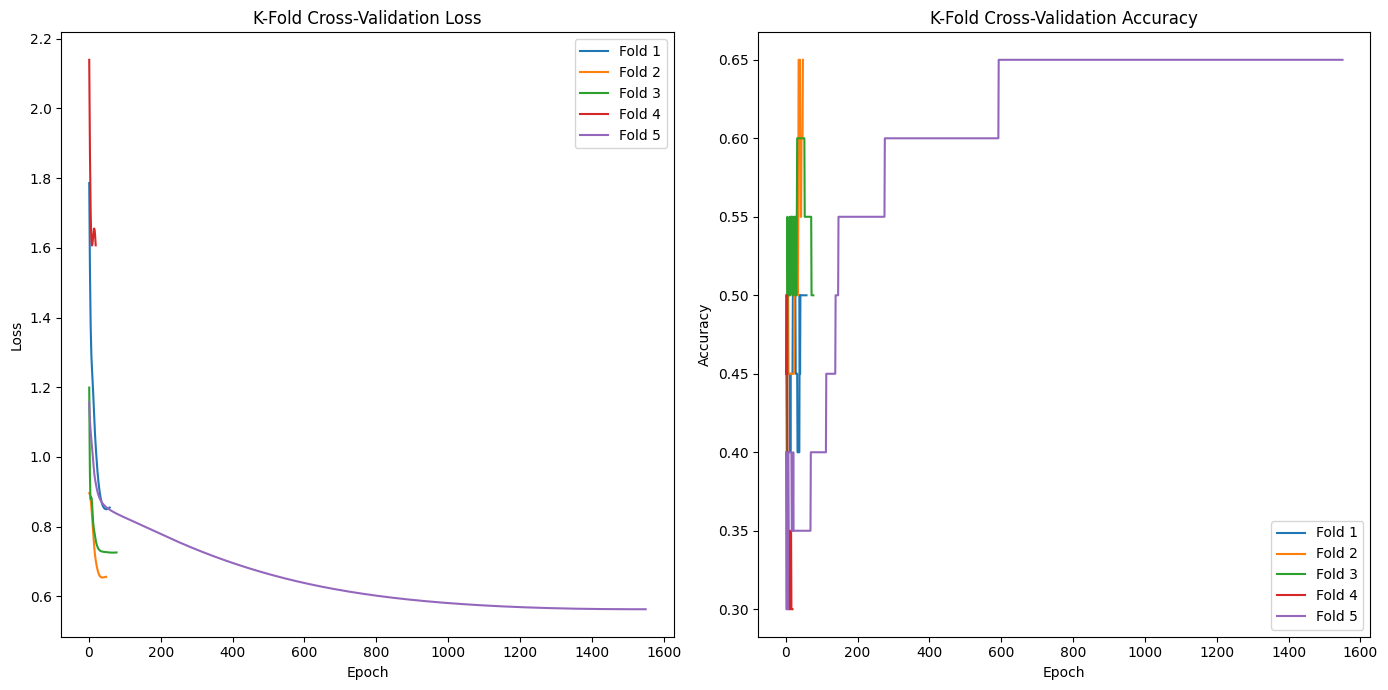

In [ ]:
for i in range(k):
    if len(fold_losses[i]) < max_epochs:
        fold_losses[i] = np.pad(fold_losses[i], (0, max_epochs - len(fold_losses[i])), constant_values=np.nan)
        fold_accuracies[i] = np.pad(fold_accuracies[i], (0, max_epochs - len(fold_accuracies[i])), constant_values=np.nan)

# Criar um eixo X com o número máximo de épocas
epochs = np.arange(1, max_epochs + 1)

# Plotar os gráficos
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

# Gráfico de Loss
for i, losses in enumerate(fold_losses):
    ax[0].plot(epochs, losses, label=f'Fold {i+1}')
ax[0].set_title('K-Fold Cross-Validation Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Gráfico de Accuracy
for i, accuracies in enumerate(fold_accuracies):
    ax[1].plot(epochs, accuracies, label=f'Fold {i+1}')
ax[1].set_title('K-Fold Cross-Validation Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# for i, history in enumerate(hists.values()):
#     plt.plot(history.history['mse'], c='tab:blue')
#     plt.plot(history.history['val_mse'], c='tab:orange')

# plt.title('model mean_squared_error')
# plt.ylabel('MSE')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()


## Question 2.

Implemente uma solução com base no modelo de aprendizado relacional contendo meta-redes para conectar conceitos das premissas. Este modelos deve conter 11 redes, uma para cada um dos seguintes conceitos conforme definição das paginas 136 e 137:

### metanet

In [ ]:
from keras.layers import Input, Dense, concatenate
from keras.models import Model

In [ ]:
def model_2():
    # features
    t = Input(shape=(1,), name="t")
    c = Input(shape=(1,), name="c")
    w = Input(shape=(1,), name="w")
    l = Input(shape=(1,), name="l")
    s = Input(shape=(1,), name="s")
    nc = Input(shape=(1,), name="nc")
    ls = Input(shape=(1,), name="ls")
    nl = Input(shape=(1,), name="nl")
    ncl = Input(shape=(1,), name="ncl")
    x_crc = Input(shape=(1,), name="x_crc")
    x_hex = Input(shape=(1,), name="x_hex")
    x_rec = Input(shape=(1,), name="x_rec")
    x_tri = Input(shape=(1,), name="x_tri")

    # num_cars(t,nc)
    num_cars_ = concatenate([t, nc])
    num_cars_ = Dense(20, activation="linear")(num_cars_)
    num_cars = Dense(1, activation="sigmoid", name="num_cars")(num_cars_)
    num_cars = Model(inputs=[t, nc], outputs=num_cars)

    # num_loads(t,nl)
    num_loads_ = concatenate([t, nl])
    num_loads_ = Dense(20, activation="linear")(num_loads_)
    num_loads = Dense(1, activation="sigmoid", name="num_loads")(num_loads_)
    num_loads = Model(inputs=[t, nl], outputs=num_loads)

    # num_wheels(t,c,w)
    num_wheels_ = concatenate([t, c, w])
    num_wheels_ = Dense(20, activation="linear")(num_wheels_)
    num_wheels = Dense(1, activation="sigmoid", name="num_wheels")(num_wheels_)
    num_wheels = Model(inputs=[t, c, w], outputs=num_wheels)

    # length(t,c,l)
    length_ = concatenate([t, c, l])
    length_ = Dense(20, activation="linear")(length_)
    length = Dense(1, activation="sigmoid", name="length")(length_)
    length = Model(inputs=[t, c, l], outputs=length)

    # shape(t,c,s)
    shape_ = concatenate([t, c, s])
    shape_ = Dense(20, activation="linear")(shape_)
    shape = Dense(1, activation="sigmoid", name="shape")(shape_)
    shape = Model(inputs=[t, c, s], outputs=shape)

    # num_car_loads(t,c,ncl)
    num_car_loads_ = concatenate([t, c, ncl])
    num_car_loads_ = Dense(20, activation="linear")(num_car_loads_)
    num_car_loads = Dense(1, activation="sigmoid", name="num_car_loads")(num_car_loads_)
    num_car_loads = Model(inputs=[t, c, ncl], outputs=num_car_loads)

    # load_shape(t,c,ls)
    load_shape_ = concatenate([t, c, ls])
    load_shape_ = Dense(20, activation="linear")(load_shape_)
    load_shape = Dense(1, activation="sigmoid", name="load_shape")(load_shape_)
    load_shape = Model(inputs=[t, c, ls], outputs=load_shape)

    # next_crc(t,c,x)
    next_crc_ = concatenate([t, c, x_crc])
    next_crc_ = Dense(20, activation="linear")(next_crc_)
    next_crc = Dense(1, activation="sigmoid", name="next_crc")(next_crc_)
    next_crc = Model(inputs=[t, c, x_crc], outputs=next_crc)

    # next_hex_(t,c,x)
    next_hex_ = concatenate([t, c, x_hex])
    next_hex_ = Dense(20, activation="linear")(next_hex_)
    next_hex = Dense(1, activation="sigmoid", name="next_hex")(next_hex_)
    next_hex = Model(inputs=[t, c, x_hex], outputs=next_hex)

    # next_rec(t,c,x)
    next_rec_ = concatenate([t, c, x_rec])
    next_rec_ = Dense(20, activation="linear")(next_rec_)
    next_rec = Dense(1, activation="sigmoid", name="next_rec")(next_rec_)
    next_rec = Model(inputs=[t, c, x_rec], outputs=next_rec)

    # next_tri(t,c,x)
    next_tri_ = concatenate([t, c, x_tri])
    next_tri_ = Dense(20, activation="linear")(next_tri_)
    next_tri = Dense(1, activation="sigmoid", name="next_tri")(next_tri_)
    next_tri = Model(inputs=[t, c, x_tri], outputs=next_tri)

    # east
    east = concatenate(
        [
            num_cars_,
            num_loads_,
            num_wheels_,
            length_,
            shape_,
            num_car_loads_,
            load_shape_,
            next_crc_,
            next_hex_,
            next_rec_,
            next_tri_,
        ]
    )
    east = Dense(3, activation="linear")(east)
    east = Dense(1, activation="sigmoid", name="east")(east)
    east = Model(
        inputs=[t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri],
        outputs=east,
    )

    # metanet
    metanet = Model(
        inputs=east.inputs,
        outputs=[
            num_cars.output,
            num_loads.output,
            num_wheels.output,
            length.output,
            shape.output,
            num_car_loads.output,
            load_shape.output,
            next_crc.output,
            next_hex.output,
            next_rec.output,
            next_tri.output,
            east.output,
        ],
    )

    # rules
    rules = {
        "num_cars": num_cars,
        "num_loads": num_loads,
        "num_wheels": num_wheels,
        "length": length,
        "shape": shape,
        "num_car_loads": num_car_loads,
        "load_shape": load_shape,
        "next_crc": next_crc,
        "next_hex": next_hex,
        "next_rec": next_rec,
        "next_tri": next_tri,
    }

    return metanet, east, rules


metanet, east, rules = model_2()
metanet.summary()


Model: "functional_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ t (InputLayer)            │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nc (InputLayer)           │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ nl (InputLayer)           │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ c (InputLayer)            │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ w (InputLayer)            │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ l (InputLayer)            │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ s (InputLayer)            │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ncl (InputLayer)          │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ ls (InputLayer)           │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x_crc (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x_hex (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x_rec (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ x_tri (InputLayer)        │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_132           │ (None, 2)              │              0 │ t[0][0], nc[0][0]      │
│ (Concatenate)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_133           │ (None, 2)              │              0 │ t[0][0], nl[0][0]      │
│ (Concatenate)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_134           │ (None, 3)              │              0 │ t[0][0], c[0][0],      │
│ (Concatenate)             │                        │                │ w[0][0]                │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_135           │ (None, 3)              │              0 │ t[0][0], c[0][0],      │
│ (Concatenate)             │                        │                │ l[0][0]                │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_136      

 Total params: 1,738 (6.79 KB)

 Trainable params: 1,738 (6.79 KB)

 Non-trainable params: 0 (0.00 B)

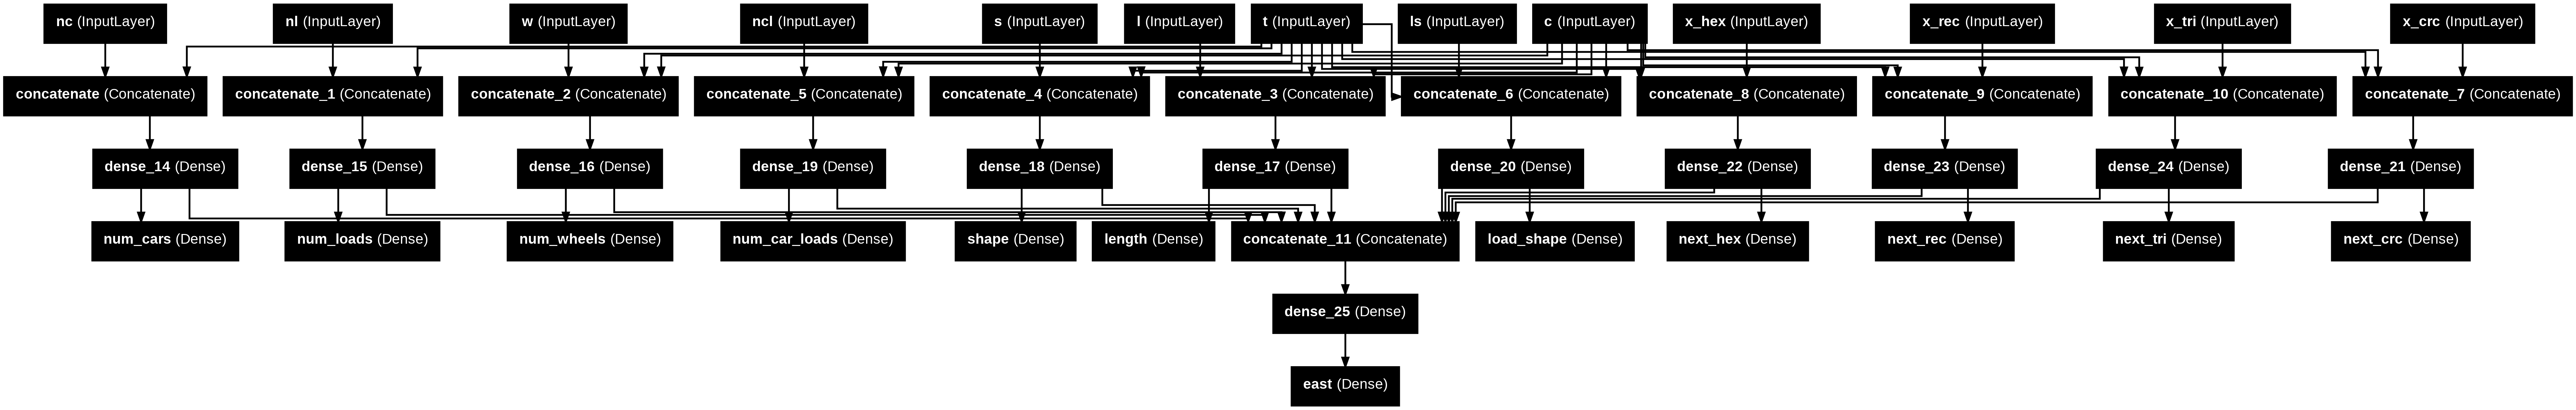

In [ ]:
plot_model(metanet, show_shapes=False, show_layer_names=True)

### Data Augmentation

In [ ]:
df = read_data()
df = df.drop("Unnamed: 0", axis = 1)
cols = [
    [
        c
        for c in df.columns
        if not (str.isdigit(c[-1])) or (str.isdigit(c[-1]) and int(c[-1]) == n)
    ]
    for n in range(1, 5)
]

data = [df[col] for col in cols]
for c, df in enumerate(data):
    df.columns = [
        name if not str.isdigit(name[-1]) else name[:-1] for name in df.columns
    ]
    df["car"] = c + 1

data = pd.concat(data)
data.reset_index(level=0, inplace=True)
data["train"] = data.pop("index")
data.T[0]


Number_of_cars                 4
Number_of_different_loads      3
num_wheels                     2
length                         1
shape                          1
num_loads                      3
load_shape                     2
Class_attribute                1
Rectangle_next_to_rectangle    0
Rectangle_next_to_triangle     1
Rectangle_next_to_hexagon      0
Rectangle_next_to_circle       0
Triangle_next_to_triangle      0
Triangle_next_to_hexagon       0
Triangle_next_to_circle        0
Hexagon_next_to_hexagon        0
Hexagon_next_to_circle         0
Circle_next_to_circle          0
car                            1
train                          0
Name: 0, dtype: object

### Train

In [ ]:
def sort_inputs(X):
    t = X["train"].T
    c = X["car"].T
    w = X["num_wheels"].T
    l = X["length"].T
    s = X["shape"].T
    nc = X["Number_of_cars"].T
    ls = X["load_shape"].T
    nl = X["Number_of_different_loads"].T
    ncl = X["num_loads"].T
    x_crc = np.sum(X[[col for col in X if col.endswith("circle")]], axis=1).T
    x_hex = np.sum(X[[col for col in X if col.endswith("hexagon")]], axis=1).T
    x_rec = np.sum(X[[col for col in X if col.endswith("rectangle")]], axis=1).T
    x_tri = np.sum(X[[col for col in X if col.endswith("triangle")]], axis=1).T

    return [t, c, w, l, s, nc, ls, nl, ncl, x_crc, x_hex, x_rec, x_tri]


def split(data, val_train):
    x_train = data.query(f"train != {val_train}")
    x_test = data.query(f"train == {val_train}")
    y_train = np.array(x_train.pop("Class_attribute"))
    y_test = np.array(x_test.pop("Class_attribute"))
    x_train = sort_inputs(x_train)
    x_test = sort_inputs(x_test)

    return x_train, x_test, y_train, y_test


In [ ]:
hists = dict()
question_2_names = [
    "Train",
    "Output of flat network",
    "Desired output",
    "Class",
]
question_2 = {name: [] for name in question_2_names}


for validation_i in tqdm.tqdm(range(0, 10)):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    x_train, x_test, y_train, y_test = split(data, validation_i)
    metanet, east, rules = model_2()

    x_train = [np.asarray(x).astype(float) for x in x_train]
    y_train = np.asarray(y_train).astype(int)
    x_test = [np.asarray(x).astype(float) for x in x_test]
    y_test = np.asarray(y_test).astype(int)

    east.compile(
        loss=binary_crossentropy, optimizer='adam', metrics=["mse", "binary_accuracy"]
    )
    hist = east.fit(
        x_train,
        y_train,
        validation_data=[x_test, y_test],
        epochs=10000,
        verbose=0,
        callbacks = [callback]
    )
    hists[validation_i] = hist

    question_2["Train"].append(validation_i)
    question_2["Output of flat network"].append(east.predict(x_test)[0][0])
    question_2["Desired output"].append(y_test[0])
    question_2["Class"].append(str_att["Class_attribute"][int(y_test[0])])


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step


 10%|█         | 1/10 [00:20<03:05, 20.62s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


 20%|██        | 2/10 [00:27<01:38, 12.37s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step


 30%|███       | 3/10 [00:34<01:10, 10.10s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


 40%|████      | 4/10 [00:46<01:05, 10.90s/it]WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x791e7dfa71c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


 50%|█████     | 5/10 [00:58<00:56, 11.28s/it]WARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x791e7b6131c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step


 60%|██████    | 6/10 [02:14<02:12, 33.15s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


 70%|███████   | 7/10 [02:45<01:37, 32.48s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


 80%|████████  | 8/10 [02:53<00:49, 24.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step


 90%|█████████ | 9/10 [03:00<00:19, 19.29s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


100%|██████████| 10/10 [03:24<00:00, 20.48s/it]


### Results

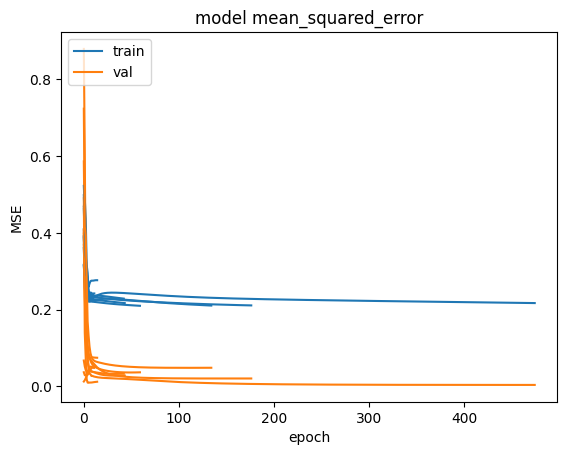

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['mse'], c='tab:blue')
    plt.plot(history.history['val_mse'], c='tab:orange')

plt.title('model mean_squared_error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


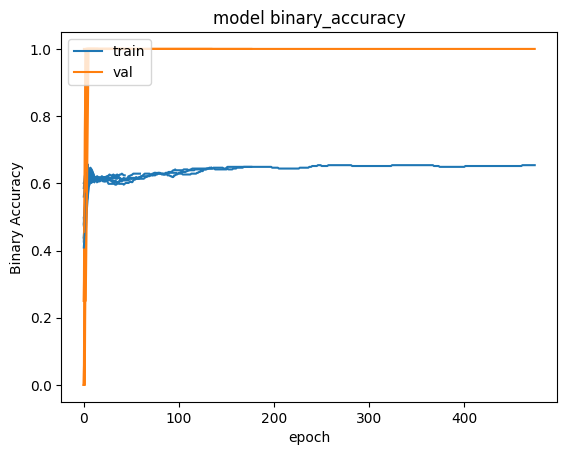

In [ ]:
for i, history in enumerate(hists.values()):
    plt.plot(history.history['binary_accuracy'], c='tab:blue')
    plt.plot(history.history['val_binary_accuracy'], c='tab:orange')

plt.title('model binary_accuracy')
plt.ylabel('Binary Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
t2 = pd.DataFrame.from_dict(question_2).round(2)
t2["Cars Accuracy"] = [hists[i].history["binary_accuracy"][-1] for i in range(0, 10)]
t2 = t2.reindex(
    columns=[
        "Train",
        "Cars Accuracy",
        "Output of flat network",
        "Desired output",
        "Class",
    ]
)
t2


,Train,Cars Accuracy,Output of flat network,Desired output,Class
0,0,0.628788,0.79,1,east
1,1,0.603535,0.68,1,east
2,2,0.611111,0.82,1,east
3,3,0.623737,0.83,1,east
4,4,0.611111,0.83,1,east
5,5,0.654040,0.93,1,east
6,6,0.648990,0.84,1,east
7,7,0.611111,0.79,1,east
8,8,0.603535,0.94,1,east
9,9,0.646465,0.82,1,east



## Question 3.



C.

In [ ]:
caseA1 = np.asarray([ 4.,  3.,  2.,  0.,  1.,  1.,  0.,  2.,  0.,  2.,  1.,  2.,  2.,
        0., 13.,  1.,  3.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]).astype(float)
        # Caso com trem contendo vagão curto e fechado

In [ ]:
caseA2 = np.asarray([4., 2., 2., 1., 2., 1., 0., 2., 0., 2., 1., 2., 2., 0., 9., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0.]) # Caso de trem com vagões curto e aberto

In [ ]:
model.predict(caseA1.reshape(1,37)) ## EAST

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


array([[0.75850886]], dtype=float32)

In [ ]:
model.predict(caseA2.reshape(1,37)) ## WEST

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[0.03048049]], dtype=float32)

b.

In [ ]:
caseB1 = np.asarray([ 5.,  3.,  2.,  0., 13.,  1.,  0.,  2.,  1.,  7.,  1.,  2.,  2.,
        0.,  9.,  1.,  3.,  2.,  0.,  4.,  1.,  3.,  2.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]) ## teto irregular

caseB2 = np.asarray([[3., 2., 2., 0., 2., 1., 2., 2., 0., 4., 1., 0., 2., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0.]]) ## dois vagões

model.predict(caseB1.reshape(1,37)) ## Vai para o LESTE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array([[0.93104255]], dtype=float32)

In [ ]:
model.predict(caseB2.reshape(1,37)) ## Vai para o LESTE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


array([[0.8356873]], dtype=float32)

c.

In [ ]:
caseC1 = np.asarray([ 5.,  3.,  2.,  0., 13.,  1.,  3.,  2.,  1.,  1.,  1.,  0.,  2.,
        0.,  1.,  1.,  0.,  2.,  1.,  1.,  1.,  2.,  2.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]) ## 3 tipos diferentes de carga

In [ ]:
model.predict(caseC1.reshape(1,37)) ## Vai para o LESTE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


array([[0.711475]], dtype=float32)

In [ ]:
caseC2 = np.asarray([4., 2., 2., 1., 1., 1., 1., 2., 1., 7., 1., 2., 2., 1., 7., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]) ## 2 tipos diferentes de carga

In [ ]:
model.predict(caseC2.reshape(1,37)) ## Vai para o OESTE

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


array([[0.01856356]], dtype=float32)